# Overview

Here we lay out an method to classify respiratory disease using a convolutional neural network. Image features are combined together to make the input. Because all these features need to be extracted it takes about 40 mins to run (make yourself a coffee or something). This method achieves an accuracy of 95% and a loss of around 0.2.

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical

# Parsing the Dataset

In [ ]:
class Diagnosis():
  def __init__ (self, id, diagnosis, image_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.image_path = image_path   

In [ ]:
def get_wav_files():
  audio_path = r"C:\Users\hp\Desktop\PRO\Respiratory_Sound_Database\audio_and_txt_files/"
  files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
  wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files 
  wav_files = sorted(wav_files)
  return wav_files, audio_path

In [ ]:
def diagnosis_data():
  diagnosis = pd.read_csv( r"C:\Users\hp\Desktop\PRO\Respiratory_Sound_Database\patient_diagnosis.csv")
  
  wav_files, audio_path = get_wav_files()
  diag_dict = { 101 : "URTI"}  
  diagnosis_list = []
  
  for index , row in diagnosis.iterrows():
    diag_dict[row[0]] = row[1]     

  c = 0
  for f in wav_files:
    diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))  
    c+=1  

  return diagnosis_list

# Feature Extraction

In [ ]:
def audio_features(filename): 
  sound, sample_rate = librosa.load(filename)
  stft = np.abs(librosa.stft(sound))  
 
  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    
  concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
  return concat

def data_points():
  labels = []
  images = []

  to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

  count = 0
  for f in diagnosis_data():
    print(count)
    labels.append(to_hot_one[f.diagnosis]) 
    images.append(audio_features(f.image_path))
    count+=1

  return np.array(labels), np.array(images)

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform

What is the difference between spectrogram and spectrum?
Image result for chromagram vs spectrogram
A spectrogram gives a running display of a sound signal as it occurs in real time; a spectrum, on the other hand, gives us a snapshot of the sound at a specific point in time
Compute a chromagram from a waveform or power spectrogram.

This implementation is derived from chromagram_E


Computes the tonal centroid features (tonnetz)

This representation uses the method of 1 to project chroma features onto a 6-dimensional basis representing the perfect fifth, minor third, and major third each as two-dimensional coordinates.



librosa.feature.spectral_contrast

Compute spectral contrast

Each frame of a spectrogram S is divided into sub-bands. For each sub-band, the energy contrast is estimated by comparing the mean energy in the top quantile (peak energy) to that of the bottom quantile (valley energy). High contrast values generally correspond to clear, narrow-band signals, while low contrast values correspond to broad-band noise. 1


librosa.feature.melspectrogram(

Compute a mel-scaled spectrogram.

If a spectrogram input S is provided, then it is mapped directly onto the mel basis by mel_f.dot(S).

If a time-series input y, sr is provided, then its magnitude spectrogram S is first computed, and then mapped onto the mel scale by mel_f.dot(S**power).

By default, power=2 operates on a power spectrum.

# Preprocessing

In [ ]:
def preprocessing(labels, images):    

  # Remove Asthma and LRTI
  images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
  labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)  

  # Format new data
  y_train = np.reshape(y_train, (y_train.shape[0], 6))
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  y_test = np.reshape(y_test, (y_test.shape[0], 6))
  X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

  return X_train, X_test, y_train, y_test

In [ ]:
start = timer()

labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)

print('Time taken: ', (timer() - start))

0
1
2
3


C:\Users\hp\anaconda3\envs\scipy\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

# Convolutional Neural Network 

In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=1)

Epoch 1/10
4/4 [==============================] - 4s 672ms/step - loss: 5.3893 - accuracy: 0.7640 - val_loss: 1.6176 - val_accuracy: 0.8859
Epoch 2/10
4/4 [==============================] - 2s 595ms/step - loss: 1.6499 - accuracy: 0.6821 - val_loss: 0.7441 - val_accuracy: 0.8152
Epoch 3/10
4/4 [==============================] - 2s 602ms/step - loss: 0.7498 - accuracy: 0.7804 - val_loss: 0.5386 - val_accuracy: 0.8967
Epoch 4/10
4/4 [==============================] - 3s 912ms/step - loss: 0.6216 - accuracy: 0.8499 - val_loss: 0.4453 - val_accuracy: 0.8967
Epoch 5/10
4/4 [==============================] - 4s 920ms/step - loss: 0.5433 - accuracy: 0.8527 - val_loss: 0.4947 - val_accuracy: 0.8587
Epoch 6/10
4/4 [==============================] - 3s 798ms/step - loss: 0.5549 - accuracy: 0.8458 - val_loss: 0.3885 - val_accuracy: 0.8967
Epoch 7/10
4/4 [==============================] - 4s 953ms/step - loss: 0.5287 - accuracy: 0.8568 - val_loss: 0.3866 - val_accuracy: 0.8967
Epoch 8/10
4/4 [====

# Evaluation

Accuracy: 90%
Loss: 0.3228



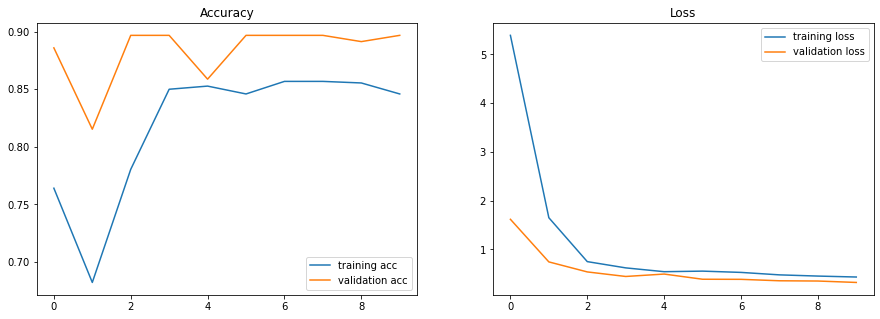

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

6/6 [==============================] - 0s 31ms/step
                precision    recall  f1-score   support

          COPD       0.90      1.00      0.95       165
       Healthy       0.00      0.00      0.00         7
          URTI       0.00      0.00      0.00         4
Bronchiectasis       0.00      0.00      0.00         4
     Pneumoina       0.00      0.00      0.00         3
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.90       184
     macro avg       0.15      0.17      0.16       184
  weighted avg       0.80      0.90      0.85       184



C:\Users\samartha bhatta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

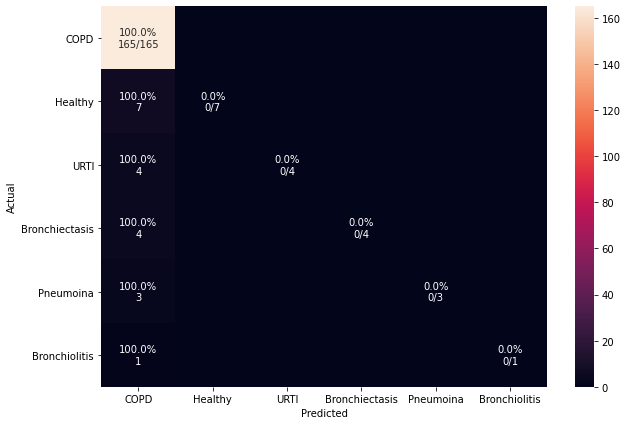

In [ ]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [ ]:
preds = model.predict(r"C:\Users\hp\Desktop\PRO\Respiratory_Sound_Database\audio_and_txt_files\224_1b2_Al_sc_Meditron.wav")

NameError: name 'model' is not defined

In [ ]:
model.predict(X_test)

6/6 [==============================] - 0s 28ms/step


array([[9.99994278e-01, 3.56190276e-06, 3.80330878e-10, 1.25269294e-12,
        7.53256302e-08, 2.05533865e-06],
       [9.99985814e-01, 1.40072225e-05, 1.39656223e-12, 3.25744466e-16,
        3.53479805e-08, 4.15472670e-08],
       [5.48258722e-01, 1.03845291e-01, 1.10537730e-01, 1.19058222e-01,
        7.37496465e-02, 4.45504151e-02],
       ...,
       [8.50079298e-01, 3.94828767e-02, 1.09423008e-02, 2.11834861e-03,
        7.69468322e-02, 2.04303246e-02],
       [9.98393714e-01, 9.67904285e-04, 1.07911637e-06, 1.51404311e-08,
        5.11480845e-04, 1.25786290e-04],
       [7.21711695e-01, 5.98782972e-02, 7.39725493e-03, 7.78441667e-04,
        1.80194139e-01, 3.00401505e-02]], dtype=float32)

In [ ]:
y_test


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
a=X_test[0]

In [7]:
class car:
  def __init__(a, m, y, ma, mo):
    a.milage =m
    a.year = y
    a.make = ma
    a.model = mo
  def age(b, current_year):
    return current_year - b.year
  def milagel1(self):
    print("print a milage of car", self.milage)
  def __str__(c): 
    return "this is my car class i have created"
  
 



In [12]:
nano = car(20, 2020, 234234, "23334fwew") 
nano.milage

20